<a href="https://colab.research.google.com/github/Holmes-Alan/ARKA_track1/blob/main/ARKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps

1. prepare data
2. define neural network architecture
3. define loss function and optimiser
4. train the network on training dataset
5. test the network on testing dataset

## prerequisite

prepare data files and required modules


In [ ]:
# change to working directory
%cd drive/MyDrive/ARKA_demo

/content/drive/MyDrive/ARKA_demo


In [ ]:
# check the data files exist
%ls

ARKA.ipynb     data_load.py    __pycache__/  testing_gt.pk  tmp.pptx     validation_gt.pk
checkpoint.pt  input_list.txt  readme.jpg    testing.pk     training.pk


In [ ]:
# load required python modules
import pandas as pd  # for processing DataFrame
import numpy as np  # for processing array
import torch  # deep learning framework
from torch import nn  # nerual network module
from torch.utils.data import DataLoader  # prepare dataset
import matplotlib.pyplot as plt  # ploting
import time  # timer

# load chemical data, see "data_load.py" for details
from data_load import ChemicalDataloader

## Prepare dataset

Dataset is usuallly divided into 3 subsets: training/validation/testing  
- training set: for fitting the model on the data
- validation set: unbiased measurement of ongoing training, for early stopping to prevent over-fitting
- testing set: measure the performance of the trained model after training

PyTorch Dataset class is a wrapper of data samples  
PyTorch Dataloader is utility class to get batches from Dataset

PyTorch neural networks support mini-batch natively, network input should be batched.

In [ ]:
train_dataset = ChemicalDataloader("training.pk")  # load train dataset
val_dataset = ChemicalDataloader("validation_gt.pk")  # load validation dataset
test_dataset = ChemicalDataloader("testing_gt.pk")  # load test dataset

# initiate a train dataloader, set batch size, shuffle for each epoch
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# initiate a validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# initiate a test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# alternative, split the validation with ground truch for both validation and test
# val_dataloader = DataLoader(
#     torch.utils.data.Subset(val_dataset, range(len(val_dataset)//2)),
#     batch_size=64, shuffle=True)
# test_dataloader = DataLoader(
#     torch.utils.data.Subset(val_dataset, range(len(val_dataset)//2, len(val_dataset))),
#     batch_size=64, shuffle=True)

## Define network architecture

1. define the netowrk layers in `__init__()`
2. define how data propagate through the layers in `forward()
`

In [ ]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron
    '''
    def __init__(self):
        """define network architecuture"""
        super().__init__()  # call the init of super class, python convention
        # Sequential is a contianer that chain its layers in order
        self.layers = nn.Sequential(
            nn.Linear(49, 300),  # input layer to 1st hidden layer
            nn.ReLU(),  # activation function
            nn.Linear(300, 600),  # 1st hidden layer to 2nd hidden layer
            nn.ReLU(),  # activation function
            nn.Linear(600, 46*12)  # output layer, flatten the multidimension output
        )


    def forward(self, x):
        """Forward pass"""
        outputs = self.layers(x)  # inputs pass all layers and get outputs
        outputs = outputs.reshape((-1,46,12))  # reshape to the original output dimension
        return outputs

# Initialize the MLP model
mlp = MLP()

## Define loss function and optimiser

In [ ]:
# Define the loss function and optimizer

# loss func by default return the mean loss of each samples
loss_function = nn.MSELoss()  # Mean square error

# bind the optimiser on the model weights
optimiser = torch.optim.Adam(mlp.parameters(), lr=1e-4)  # adam optimiser

## Training

```python
for epoch in epochs:
    for batch in dataloader:
        intput, target = batch

        # 1. forward propagation
        output = model(input)

        optimiser.zero_grad()  # clear last gradient

        # 2. comute loss
        loss = loss_func(output, target)

        # 3. backward propagation
        loss.backwards()

        # 4. update weights
        optimiser.step()
```

### speed up with GPU
define a device first to set the target running platform

`model.to(device)` or `tensor.to(device)` to move model/tensor to target device

be aware of their location, make sure model and tensor on the same platform

In [ ]:
# set device to cpu
device = torch.device('cpu')

In [ ]:
# set device to cuda GPU if available
# if using colab, check colab runtime type
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)
mlp.to(device)  # move model to target device

cpu


MLP(
  (layers): Sequential(
    (0): Linear(in_features=49, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=552, bias=True)
  )
)

### Training loop

In [ ]:
def prepare_data(batch):
    """reshape data for network input

    data from ChemicalDataloader is a dictionary, two input features are seperate
    this function extract data from dict and concatenate input features
    """
    env = batch['environ']  # envoriment features
    init = batch['initial_value']  # inital chemical status
    targets = batch['output']  # target future chemical status

    inputs = torch.cat([env, init], dim=1)  # concatenate features

    inputs = inputs.to(device)  # move inputs tensor to device
    targets = targets.to(device)  # move targets tensor to device

    return inputs, targets  # return feature and ground truth

In [ ]:
# double check the shape of tensors
sample1 = train_dataset[0]  # first data sample
# print the shape of features and ground truth
print(sample1['environ'].shape,
      sample1['initial_value'].shape,
      sample1['output'].shape)
batch1 = next(iter(train_dataloader))  # first batch
input1, targets1 = prepare_data(batch1)  # get inputs and targets
print(input1.shape, targets1.shape)  # print their shape

(3,) (46,) (46, 12)
torch.Size([64, 49]) torch.Size([64, 46, 12])


In [ ]:
# Set fixed random number seed for reproduction
torch.manual_seed(42)

# Early stopping parameter
val_patience = 5  # wait how many epochs when validation loss does not decrease
val_count = 0  # number of epochs that validation loss does not decrease
val_loss_min = np.Inf  # current minimal validation loss
early_stopped = False  # whether has reached the best validation loss
best_epoch = 0  # which epoch produced the optimal model

# for log
print_frequency = 100  # log message every x batches

train_losses_epoch = []  # average train loss of each epoch
val_losses_epoch = []  # average validation loss of each epoch

training_start_time = time.time()  # start time of training

# Run the training loop
for epoch in range(100): # max epochs

    # set model to train mode, PyTorch convention,
    # because some layers behave differently during training and inferencing
    mlp.train()

    running_loss = 0.0  # loss of recent batches
    train_loss_epoch = 0.0  # train loss of batches in one epoch
    val_loss_epoch = 0.0  # validation loss of batches in one epoch

    # Print epoch
    print(f'\nStarting epoch {epoch+1}')

    # Iterate over the DataLoader for training data
    for i, batch in enumerate(train_dataloader):

        # Get and prepare inputs
        inputs, targets = prepare_data(batch)


        # Zero the gradients
        optimiser.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimiser.step()

        # Print statistics
        running_loss += loss.item()  # accumulate loss of this batch

        if i % print_frequency == print_frequency-1:  # triger print
            # average loss every `print_frequency`
            avg_loss = running_loss / print_frequency
            print(f"Loss after mini-batch {i+1:5d}: {avg_loss:.9f}")  # print
            train_loss_epoch += running_loss
            running_loss = 0.0  # reset loss accumulator

    train_loss_epoch /= len(train_dataloader)  # average loss of this epoch
    train_losses_epoch.append(train_loss_epoch)  # store loss for each epoch
    print(f"Training has been "
          f"{(time.time()-training_start_time) / 60:.2f} minutes")

    # early stopping

    # set model to evaluation model, PyTorch convention,
    # because some layers behave differently during training and infernceing
    mlp.eval()
    # validation loss of one batch
    val_loss_epoch = 0
    # no_grad(): context manager, turn off gradient when evaluating,
    # turn on gradient automatically when leave the `with` block
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            # Get and prepare inputs
            inputs, targets = prepare_data(batch)
            # predict the output with mlp model
            predicts = mlp(inputs)
            # compute test loss, convert from tensor to float, then accumulate
            val_loss_epoch += loss_function(predicts, targets).item()

    val_loss_epoch /= len(val_dataloader)  # average loss of this epoch
    val_losses_epoch.append(val_loss_epoch)  # store loss for each epoch
    print(f"Validation loss: {val_loss_epoch}")

    # if the validation loss decrease, model after this epoch is better,
    # therefore for store the current model as the 'best' model for now
    if val_loss_epoch < val_loss_min:
        if not early_stopped:  # stop saving model if should be stopped
            torch.save(mlp.state_dict(), "checkpoint.pt")  # save model to file
            val_loss_min = val_loss_epoch  # update best loss
            val_count = 0  # reset counter
            best_epoch = epoch  # record which epoch
    else:  # otherwise, we wait a few epochs until no longer decrease
        val_count += 1  # increase counter
        if val_count > val_patience:  # if the validation loss hasn't improved
            early_stopped = True  # should stop
            print(f"early stop at epoch {epoch} \n"
                  f"best validation loss is {val_loss_min}")  # print
            break  # early stop



# Process is complete.
print("Training process has finished."  # log
      f"using {(time.time()-training_start_time) / 60:.2f} minutes")



Starting epoch 1
Loss after mini-batch   100: 0.052513020
Loss after mini-batch   200: 0.002706159
Loss after mini-batch   300: 0.002394916
Loss after mini-batch   400: 0.001947719
Loss after mini-batch   500: 0.001479351
Loss after mini-batch   600: 0.001178011
Loss after mini-batch   700: 0.001086171
Loss after mini-batch   800: 0.000979855
Loss after mini-batch   900: 0.000857850
Loss after mini-batch  1000: 0.000741549
Loss after mini-batch  1100: 0.000636615
Loss after mini-batch  1200: 0.000554232
Loss after mini-batch  1300: 0.000499381
Training has been 0.40 minutes
Validation loss: 0.0004228658637929902

Starting epoch 2
Loss after mini-batch   100: 0.000408015
Loss after mini-batch   200: 0.000371383
Loss after mini-batch   300: 0.000336041
Loss after mini-batch   400: 0.000309718
Loss after mini-batch   500: 0.000288515
Loss after mini-batch   600: 0.000268041
Loss after mini-batch   700: 0.000253070
Loss after mini-batch   800: 0.000245295
Loss after mini-batch   900: 0.00

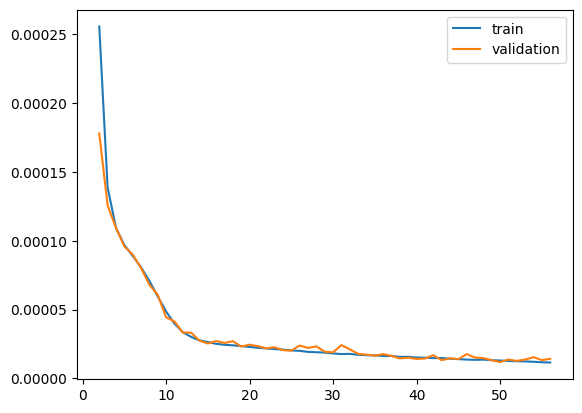

In [ ]:
# Training loss
# skip the first epoch since its loss is much larger
# and make it hard to scale the plot

# plot train loss per epoch
plt.plot(range(2,len(train_losses_epoch)+1), train_losses_epoch[1:], label="train")
# plot validation loss per epoch
plt.plot(range(2,len(train_losses_epoch)+1), val_losses_epoch[1:], label="validation")
plt.legend()  # show the legends
plt.show()  # show plot

## Testing

In [ ]:
# test on testing dataset

best_model = MLP()
best_model.load_state_dict(torch.load("checkpoint.pt"))
best_model.to(device)

test_loss = 0  # sum of each testing batch

# set model to evaluation mode, PyTorch convention,
# because some layers behave differently during training and infernceing
best_model.eval()

# no_grad(): context manager, turn off gradient when evaluating,
# turn on gradient automatically when leave the `with` block
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):  # for each test batch
        # Get and prepare inputs
        inputs, targets = prepare_data(batch)
        # predict the output with mlp model
        predicts = best_model(inputs)
        # compute test loss, convert from tensor to float, then accumulate
        test_loss += loss_function(predicts, targets).item()
    # average loss of all batches
    test_loss /= len(test_dataloader)

print(f"Loss on test dataset is {test_loss}")  # print the testing loss

Loss on test dataset is 1.1991272164586542e-05
